# **Dataset 5**

### **Import Packages**

In [24]:
import os
import sys
import multiprocessing
import subprocess
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

sys.path.append(os.path.abspath("../src"))

from generation.data_synthesizer import ds_generate_data
from generation.synthetic_data_vault import sdv_generate_data
from evaluation.utility import run_utility_eval
from evaluation.resemblance import pairwise_correlation_diff, jsd, wd
from evaluation.privacy import dcr, nndr, mia

### **Exploratory Data Analysis**

In [25]:
data_path = "../data/original_data/5_portuguese_school/5_portuguese_school.csv"
original_data = pd.read_csv(data_path)
original_data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [26]:
original_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [27]:
original_data.isnull().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

In [28]:
original_data.nunique()

school         2
sex            2
age            8
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
dtype: int64

In [29]:
# Check categorical columns
categorical_cols = original_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col, original_data[col].unique())

school ['GP' 'MS']
sex ['F' 'M']
address ['U' 'R']
famsize ['GT3' 'LE3']
Pstatus ['A' 'T']
Mjob ['at_home' 'health' 'other' 'services' 'teacher']
Fjob ['teacher' 'other' 'services' 'health' 'at_home']
reason ['course' 'other' 'home' 'reputation']
guardian ['mother' 'father' 'other']
schoolsup ['yes' 'no']
famsup ['no' 'yes']
paid ['no' 'yes']
activities ['no' 'yes']
nursery ['yes' 'no']
higher ['yes' 'no']
internet ['no' 'yes']
romantic ['no' 'yes']


<Axes: xlabel='G3', ylabel='Count'>

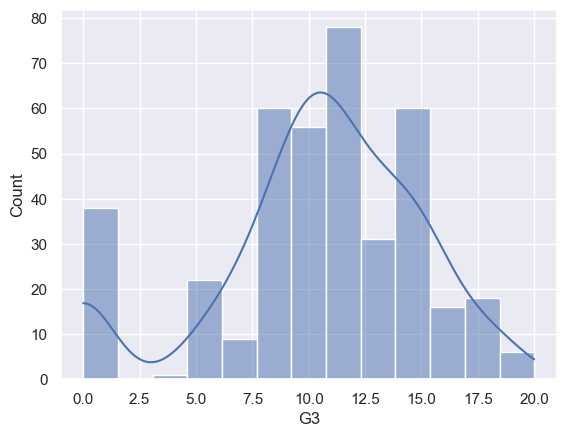

In [30]:
# Check class distribution
sns.histplot(original_data['G3'], kde=True)

### **Synthetic Data Generation**

In [31]:
# Set the start method of the multiprocessing module to 'fork' to avoid an error
multiprocessing.set_start_method('fork', force=True)

# Number of samples to generate
n = 5000

original_data_path = "../data/original_data/5_portuguese_school/"
train_file = os.path.join(original_data_path, "train_data.csv")
test_file = os.path.join(original_data_path, "test_data.csv")

# Prüfen, ob beide Dateien existieren
if os.path.isfile(train_file) and os.path.isfile(test_file):
    train_data = pd.read_csv(train_file)
    test_data = pd.read_csv(test_file)
    print("Train and test data loaded.")
else:
    train_data, test_data = train_test_split(original_data, test_size=0.3, random_state=42)
    train_data.to_csv(train_file, index=False)
    test_data.to_csv(test_file, index=False)
    print("Train and test data saved.")

Train and test data loaded.


In [32]:
synth_path = "../data/synthetic_data/5_portuguese_school/"
dataset_name = "5_portuguese_school"
csv_files = [file for file in os.listdir(synth_path) if file.endswith(".csv")]

if len(csv_files) == 0:
    # Use train_data.csv to fit SDG models and generate synthetic data
    data_path = original_data_path + "train_data.csv"
    arguments = [data_path, str(n), dataset_name]

    print("Sampling synthpop...")
    result = subprocess.run(['Rscript', '../src/generation/synthpop.R',   *arguments], capture_output=True, text=True)

    print("Sampling DataSynthesizer...")
    ds_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)

    sdv_generate_data(data_path=data_path, num_samples=n, dataset_name=dataset_name)
else:
    print("Synthetic data already exists.")

Synthetic data already exists.


Encode all categorical columns of both original (train+test) data and synthetic data using label encoding

In [33]:
# Load the synthetic data as dataframe
synthpop = pd.read_csv(synth_path + "synthpop.csv")
ds = pd.read_csv(synth_path + "ds.csv")
tvae = pd.read_csv(synth_path + "tvae.csv")
gaussian_copula = pd.read_csv(synth_path + "gaussian_copula.csv")
copula_gan = pd.read_csv(synth_path + "copula_gan.csv")
ctgan = pd.read_csv(synth_path + "ctgan.csv")

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    train_data[col] = le.fit_transform(train_data[col])
    test_data[col] = le.fit_transform(test_data[col])

    synthpop[col] = le.fit_transform(synthpop[col])
    ds[col] = le.fit_transform(ds[col])
    tvae[col] = le.fit_transform(tvae[col])
    gaussian_copula[col] = le.fit_transform(gaussian_copula[col])
    copula_gan[col] = le.fit_transform(copula_gan[col])
    ctgan[col] = le.fit_transform(ctgan[col])

    label_encoders[col] = le


In [34]:
ctgan.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,0,1,17,1,0,1,1,4,4,2,...,1,1,4,1,1,5,38,13,17,17
1,0,0,18,1,0,1,2,2,4,2,...,4,2,2,2,1,1,4,5,15,17
2,0,1,17,1,0,1,2,3,3,2,...,4,3,3,1,3,5,20,7,16,7
3,0,1,17,1,1,1,2,3,3,0,...,4,2,2,1,2,3,8,7,16,4
4,0,1,17,0,0,1,4,1,3,2,...,2,2,4,2,1,3,5,5,17,20


### **Utility Evaluation**

Prepare utility evaluation

In [35]:
synth_datasets = [synthpop, ds, tvae, gaussian_copula, copula_gan, ctgan]
model_names = ["synthpop", "ds", "tvae", "gaussian_copula", "copula_gan", "ctgan"]
target_col = "G3"

for synth_dataset in synth_datasets:
    synth_dataset.drop(["G1", "G2"], axis=1, inplace=True)
    synth_dataset[target_col] = pd.cut(synth_dataset[target_col], bins=[-1, 7, 14, 20], labels=[0, 1, 2])

train_data.drop(["G1", "G2"], axis=1, inplace=True)
train_data[target_col] = pd.cut(train_data[target_col], bins=[-1, 7, 14, 20], labels=[0, 1, 2])
test_data.drop(["G1", "G2"], axis=1, inplace=True)
test_data[target_col] = pd.cut(test_data[target_col], bins=[-1, 7, 14, 20], labels=[0, 1, 2])

In [36]:
train_data["G3"].unique()

[1, 2, 0]
Categories (3, int64): [0 < 1 < 2]

Run random forest classifier for utility evaluation

In [37]:
rf_results = {}
rows = []
rf_df = pd.read_csv("../data/results/tables/rf.csv")

if (rf_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        rf_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_data, target_col, "random_forest")

        acc_diff = rf_results[model_names[i]]["acc_diff"]
        f1_diff = rf_results[model_names[i]]["f1_diff"]
        roc_auc_diff = rf_results[model_names[i]]["roc_auc_diff"]

        rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=rf_df.columns)
    rf_df = pd.concat([rf_df, rows], ignore_index=True)
    rf_df.to_csv("../data/results/tables/rf.csv", index=False)
    rf_df.tail(7)

Entry for 5 Portuguese School already exists.


Run logistic regression for utility evaluation

In [38]:
lr_results = {}
lr_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (lr_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        lr_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_data, target_col, "logistic_regression")

        acc_diff = lr_results[model_names[i]]["acc_diff"]
        f1_diff = lr_results[model_names[i]]["f1_diff"]
        roc_auc_diff = lr_results[model_names[i]]["roc_auc_diff"]

        rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=lr_df.columns)
    lr_df = pd.concat([lr_df, rows])
    lr_df.to_csv("../data/results/tables/lr.csv", index=False)
    lr_df.tail(7)

Entry for 5 Portuguese School already exists.


Run multilayer perceptron (MLP)

In [39]:
mlp_results = {}
mlp_df = pd.read_csv("../data/results/tables/lr.csv")
rows = []

if (mlp_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        mlp_results[model_names[i]] = run_utility_eval(train_data, test_data, synth_data, target_col, "multilayer_perceptron")

        acc_diff = mlp_results[model_names[i]]["acc_diff"]
        f1_diff = mlp_results[model_names[i]]["f1_diff"]
        roc_auc_diff = mlp_results[model_names[i]]["roc_auc_diff"]

        rows.append([5, model_names[i], acc_diff, f1_diff, roc_auc_diff])

    rows = pd.DataFrame(rows, columns=mlp_df.columns)
    mlp_df = pd.concat([mlp_df, rows])
    mlp_df.to_csv("../data/results/tables/lr.csv", index=False)
    mlp_df.tail(7)

Entry for 5 Portuguese School already exists.


### **Resemblance**

Run multiple resemblance metrics: Difference in pairwise correlation, Jensen-Shannon divergence, Wasserstein distance

- Correlation distance diff : lower values are better
- JSD in [0,1] range: lower values are better
- WD: lower values are better


**Difference in pairwise correlation:**

In [40]:
corr_diff_df = pd.read_csv("../data/results/tables/corr_diff.csv")
rows = []

if (corr_diff_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = pairwise_correlation_diff(train_data, synth_data)
        rows.append([5,model_names[i], result])

    rows = pd.DataFrame(rows, columns=corr_diff_df.columns)
    corr_diff_df = pd.concat([corr_diff_df, rows])
    corr_diff_df.to_csv("../data/results/tables/corr_diff.csv", index=False)
    corr_diff_df.tail(7)

Entry for 5 Portuguese School already exists.


**Jensen-Shannon Divergence**

In [41]:
jsd_df = pd.read_csv("../data/results/tables/jsd.csv")
rows = []

if (jsd_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = jsd(train_data, synth_data)
        rows.append([5,model_names[i], result])

    rows = pd.DataFrame(rows, columns=jsd_df.columns)
    jsd_df = pd.concat([jsd_df, rows])
    jsd_df.to_csv("../data/results/tables/jsd.csv", index=False)
    jsd_df.tail(7)

Entry for 5 Portuguese School already exists.


**Wasserstein Distance**

In [42]:
wd_df = pd.read_csv("../data/results/tables/wd.csv")
rows = []

if (wd_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = wd(train_data, synth_data)
        rows.append([5,model_names[i], result])

    rows = pd.DataFrame(rows, columns=wd_df.columns)
    wd_df = pd.concat([wd_df, rows])
    wd_df.to_csv("../data/results/tables/wd.csv", index=False)
    wd_df.tail(7)

Entry for 5 Portuguese School already exists.


### **Privacy**

Run privacy evaluation using Distance to closest Record (DCR), Nearest Neighbour Difference Ratio (NNDR) and Membership Inference Attack (MIA)

- **DCR**: a value of zero indicates that the synthetic record is an identical copy of the original
one -> leak of real information, higher values indicate more privacy

- **NNDR**: ratio is within [0,1], higher values indicate better privacy

- **MIA**: both accuracy and precision should be below 0.5 for all thresholds for strong privacy preservation

**Distance to closest record (DCR)**

In [43]:
dcr_df = pd.read_csv("../data/results/tables/dcr.csv")
rows = []
if (dcr_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = dcr(train_data, synth_data, model_names[i], dataset_name=dataset_name, save_hist=True)
        result_within_real = dcr(train_data, synth_data, model_names[i], dataset_name=dataset_name, within="Original", save_hist=True)
        result_within_synth = dcr(train_data, synth_data, model_names[i], dataset_name=dataset_name, within="Synthetic", save_hist=True)
        rows.append([5,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=dcr_df.columns)
    dcr_df = pd.concat([dcr_df, rows])
    dcr_df.to_csv("../data/results/tables/dcr.csv", index=False)
    dcr_df.tail(7)

Entry for 5 Portuguese School already exists.


**Nearest Neighbor distance ratio (NNDR)**

In [44]:
nndr_df = pd.read_csv("../data/results/tables/nndr.csv")
rows = []
if (nndr_df["Dataset"] == 5).any():
    print("Entry for 5 Portuguese School already exists.")
else:
    for i, synth_data in enumerate(synth_datasets):
        result = nndr(train_data, synth_data)
        result_within_real = nndr(train_data, synth_data, within="Original")
        result_within_synth = nndr(train_data, synth_data, within="Synthetic")
        rows.append([5,model_names[i], result, result_within_real, result_within_synth])

    rows = pd.DataFrame(rows, columns=nndr_df.columns)
    nndr_df = pd.concat([nndr_df, rows])
    nndr_df.to_csv("../data/results/tables/nndr.csv", index=False)
    nndr_df.tail(7) 

Entry for 5 Portuguese School already exists.


**Membership Inference Attack (MIA)**

In [45]:
mia_results = {}
if (os.path.isfile("../data/results/plots/mia/5_portuguese_school/ds_mia_accuracy.png")):
    print("MIA results already exist.")
else:
    for i, synth_data in enumerate(synth_datasets):
        mia_results[model_names[i]] = mia(train_data, synth_data, model_names[i], dataset_name=dataset_name, save_plts=True)


MIA results already exist.
